In [79]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
import torchvision.transforms as transforms
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import PIL
from pathlib import Path
import random
from tqdm import tqdm

In [80]:
import warnings
warnings.filterwarnings("ignore")

# 2 Localisation



В задаче детекции участвовали фотографии 20 классов:
- black_kite
- chaffinch
- common_magpie
- common_raven
- crested_tit
- eurasian_jay
- eurasian_pygmy-owl
- eurasian_tree_sparrow
- european_turtle-dove
- great_spotted_woodpecker
- hazel_grouse
- northern_harrier
- rock_pigeon
- ruddy_shelduck
- snow_goose
- snowy_owl
- waxwing
- white_stork
- white_wagtail
- willow_grouse

Изображения распологаются в соответствующих папках в `bird_imgs`.
С помощью Label Studio для каждого изображения были найдены bounding boxы. json-файл с координатами и лэйблами располагается в папке `bird_bbox`

In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
cd "/content/drive/MyDrive/bird_species"

/content/drive/MyDrive/bird_species


In [83]:
data_path = './bird_dataset/' #путь до папки с датасетом
img_path = './bird_dataset/bird_imgs'
bbox_path = './bird_dataset/bird_bbox/'

In [84]:
# img_folder = Path(img_path)
# for name in img_list:
#     image = PIL.Image.open(img_folder / name)
#     try:
#       channel = np.array(image).shape[2]
#       if channel != 3:
#           print(name)
#     except IndexError:
#         print(f'Some channel problem in {name}')


## 2.1 Dataset & Dataloader

In [85]:
IMG_SIZE = [416, 416]
BATCH_SIZE = 10
EPOCHES = 10
num_classes = 20
S=[13, 26, 52]

In [86]:
ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
] 

In [87]:
labels = sorted(['black_kite', 
                 'chaffinch', 
                 'common_magpie', 
                 'common_raven', 
                 'crested_tit', 
                 'eurasian_jay', 
                 'eurasian_pygmy-owl', 
                 'eurasian_tree_sparrow', 
                 'european_turtle-dove', 
                 'great_spotted_woodpecker', 
                 'hazel_grouse', 
                 'northern_harrier', 
                 'rock_pigeon', 
                 'ruddy_shelduck', 
                 'snow_goose', 
                 'snowy_owl', 
                 'waxwing', 
                 'white_stork', 
                 'white_wagtail', 
                 'willow_grouse'])

label_dict = {labels[i]:i for i in range(0, len(labels))}
re_label_dict = {i:labels[i] for i in range(0, len(labels))}

In [88]:
def map_label(label):
    return label_dict[label]

In [89]:
# for open txt file with bounding boxes and labels for each image
def open_txt(txt_file):    
    box = []
    with open(txt_file) as f:
        for line in f:
            mylist = line.strip().split(' ')
            mylist[0] = int(mylist[0])
            mylist[1:] = [float(num) for num in mylist[1:]]
            box.append(mylist)

    return box

### Dataset augmentation 

In [90]:
def horizontal_flip(image, boxes, p_value):
    flip_boxes = boxes
    flip_image = image
    if random.random() < p_value:
        # change only x values
        flip_boxes = [[box[0], (1 - box[1]), box[2], box[3], box[4]] for box in boxes]
        # Flip image horizontally with bounding boxes
        flip_image = transforms.functional.hflip(image)
    return flip_image, flip_boxes
    

In [91]:
def transform(image, boxes, img_size, split):
    # different transformations for 'train' or 'test' splits
    assert split in {'TRAIN', 'TEST'}

    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    new_image = image
    new_boxes = boxes
    

    if split == 'TRAIN':

        img_blurrer = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
        img_autocontrast = transforms.RandomAutocontrast(p=1)

        # 0.5 probability of horizontal flip
        new_image, new_boxes = horizontal_flip(new_image, new_boxes, .5)
        
        if random.random() < 0.4:
            new_image = img_blurrer(new_image)
            new_image = img_autocontrast(new_image)


    base_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Resize(img_size),
                                         transforms.Normalize(mean=mean, std=std)]) 
       
    new_image = base_transform(new_image)

    return new_image, new_boxes


### Intersection over union

In [92]:
def iou_width_height(boxes1, boxes2):
    """
    Parameters:
        boxes1 (tensor): width and height of the first bounding boxes
        boxes2 (tensor): width and height of the second bounding boxes
    Returns:
        tensor: Intersection over union of the corresponding boxes
    """
    intersection = torch.min(boxes1[..., 0], boxes2[..., 0]) * torch.min(
        boxes1[..., 1], boxes2[..., 1]
    )
    union = (
        boxes1[..., 0] * boxes1[..., 1] + boxes2[..., 0] * boxes2[..., 1] - intersection
    )
    return intersection / union

In [93]:
def intersection_over_union(boxes_preds, boxes_labels):
    """
    This function calculates intersection over union (iou) given pred boxes
    and target boxes.
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
    Returns:
        tensor: Intersection over union for all examples
    """

    box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
    box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
    box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
    box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2


    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

### Make Dataset

In [94]:
class BBoxDataset(Dataset):
    def __init__(self, img_folder, bbox_folder, img_size, S, anchors, num_classes, split):
        super().__init__()
        self.img_folder = Path(img_folder)
        self.bbox_folder = Path(bbox_folder)
        self.img_size = img_size
        self.S = S
        self.anchors = torch.Tensor(anchors[0] + anchors[1] + anchors[2])
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.C = num_classes
        self.ignore_iou_thresh = 0.5
        self.img_list = os.listdir(self.img_folder)

        self.split = split.upper()
        assert self.split in {'TRAIN', 'TEST'}

    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        
        image = PIL.Image.open(self.img_folder / self.img_list[idx])
        if image.mode != 'RGB':
            image = image.convert('RGB')
        box_name = self.img_list[idx][:9] + '.txt'
        boxes_file = self.bbox_folder / box_name  # that's so ugly...sorry 
        boxes = open_txt(boxes_file)

        # apply transformations
        image, boxes = transform(image, boxes, self.img_size, self.split)
        boxes = np.roll(boxes, 4, axis=1).tolist() # because we nead [x, y, w, h, label]

        targets = [torch.zeros((self.num_anchors // 3, S, S, 6)) for S in self.S]
        for box in boxes:
            iou_anchors = iou_width_height(torch.tensor(box[2:4]), self.anchors)
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)
            x, y, width, height, class_label = box
            has_anchor = [False] * 3  # one anchor for each scale
            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale
                S = self.S[scale_idx]
                i, j = int(S * y), int(S * x)  # which cell
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]
                if not anchor_taken and not has_anchor[scale_idx]:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                    x_cell, y_cell = S * x - j, S * y - i  # both between [0,1]
                    width_cell, height_cell = (
                        width * S,
                        height * S,
                    )  # can be greater than 1 since it's relative to cell
                    box_coordinates = torch.tensor(
                        [x_cell, y_cell, width_cell, height_cell]
                    )
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                    has_anchor[scale_idx] = True

                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1  # ignore prediction

        return image, tuple(targets)


Специфичный для YOLOv3 вид предсказания модели не очень удобен для оборажения bounding box'ов визуально. Ф-ция `cells_to_bboxes` нужна для преобразования предсказания обратно к виду координат box'ов

In [95]:
def cells_to_bboxes(predictions, anchors, S, is_preds=True):
    """
    predictions: tensor of size (N, 3, S, S, num_classes+5)
    anchors: the anchors used for the predictions
    S: the number of cells the image is divided in on the width (and height)
    is_preds: whether the input is predictions or the true bounding boxes
    
    OUTPUT:
    converted_bboxes: the converted boxes of sizes (N, num_anchors, S, S, 1+5) with class index,
                      object score, bounding box coordinates
    """
    BATCH_SIZE = predictions.shape[0]
    num_anchors = len(anchors)
    box_predictions = predictions[..., 1:5]
    if is_preds:
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
        box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:]) * anchors
        scores = torch.sigmoid(predictions[..., 0:1])
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1)
    else:
        scores = predictions[..., 0:1]
        best_class = predictions[..., 5:6]

    cell_indices = (
        torch.arange(S)
        .repeat(predictions.shape[0], 3, S, 1)
        .unsqueeze(-1)
        .to(predictions.device)
    )
    x = 1 / S * (box_predictions[..., 0:1] + cell_indices)
    y = 1 / S * (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))
    w_h = 1 / S * box_predictions[..., 2:4]
    converted_bboxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).reshape(BATCH_SIZE, num_anchors * S * S, 6)
    return converted_bboxes.tolist()

### Non Max Suppression

In [96]:
def nms(bboxes, iou_threshold, threshold):
    """
    Does Non Max Suppression given bboxes
    
    bboxes (list): list of lists containing all bboxes with each bboxes
    specified as [class_pred, prob_score, x1, y1, x2, y2]
    iou_threshold (float): threshold where predicted bboxes is correct
    threshold (float): threshold to remove predicted bboxes (independent of IoU)

    OUTPUT:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [box for box in bboxes if box[0] != chosen_box[0] 
                  or intersection_over_union(torch.tensor(chosen_box[2:]),
                                             torch.tensor(box[2:])) < iou_threshold ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

In [97]:
bird_set = BBoxDataset(img_path, 
                       bbox_path, 
                       img_size=IMG_SIZE, 
                       S=[13, 26, 52],
                       anchors=ANCHORS,
                       num_classes=num_classes,
                       split='train')


## 2.2 Train&validation split

In [98]:
train_size = int(0.8 * len(bird_set))
val_size = len(bird_set) - train_size
train_set, val_set = random_split(bird_set,
                                  [train_size, val_size], 
                                  generator=torch.Generator().manual_seed(42))

In [99]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## Dataset visualization 

In [100]:
def draw_a_box(box, colormap):
    width, height = IMG_SIZE[0], IMG_SIZE[1]
    cmap = plt.get_cmap(colormap)
    class_labels = labels
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
    class_pred = box[0]
    box = box[2:]
    upper_left_x = box[0] - box[2] / 2
    upper_left_y = box[1] - box[3] / 2
    rect = patches.Rectangle(
        (upper_left_x * width, upper_left_y * height),
        box[2] * width,
        box[3] * height,
        linewidth=2,
        edgecolor=colors[int(class_pred)],
        facecolor="none")
    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.text(
        upper_left_x * width,
        upper_left_y * height,
        s=class_labels[int(class_pred)],
        color="white",
        verticalalignment='bottom',
        bbox={"color": colors[int(class_pred)], "pad": 0})

    return ax

In [101]:
def show_image(images, bboxes, is_pred=False):
    img = np.array(images)
    # img = np.moveaxis(images.numpy(), 0, 2)
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

    for box in bboxes:
        ax = draw_a_box(box, "tab20b")
  
    if is_pred:
        with torch.no_grad():
            boxes_pred = model(torch.unsqueeze(img_tensor, dim=0).to(device)).cpu().numpy()[0].argmax()

            for box_pred in boxes_pred:
                ax = draw_a_box(box_pred, "tab20c")

    ax.imshow(img.clip(0,1))
    return ax
    # plt.show()

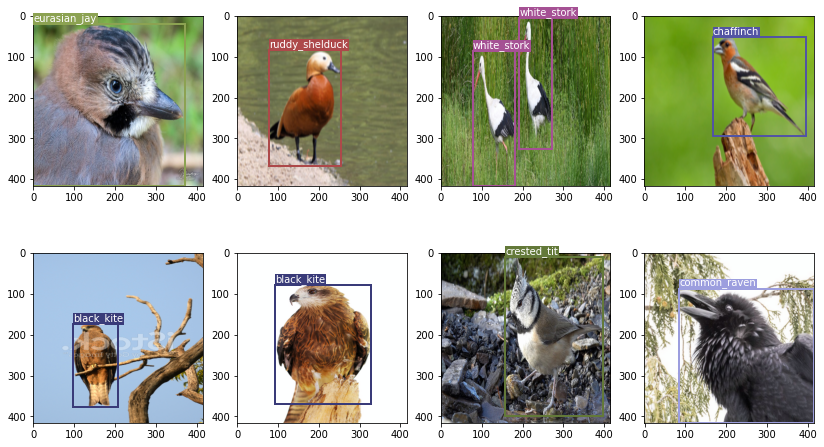

In [102]:
scaled_anchors = torch.tensor(ANCHORS) / (1 / torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2))
loader = DataLoader(bird_set, batch_size=1, shuffle=True, num_workers=2)

f = plt.figure(figsize=(14, 8))
rows = 2
columns = 4
for j in range(1,columns*rows+1):
    img, target = next(iter(loader))
    boxes = []
    for i in range(target[0].shape[1]):
        anchor = scaled_anchors[i]
        
        boxes += cells_to_bboxes(
            target[i], is_preds=False, S=target[i].shape[2], anchors=anchor
        )[0]
    boxes = nms(boxes, iou_threshold=1, threshold=0.7)

    ax = f.add_subplot(rows, columns, j)
    ax = show_image(img[0].permute(1, 2, 0).to("cpu"), boxes, is_pred=False)

plt.show()

## 2.3  Network architecture

[YOLOv3](https://arxiv.org/pdf/1804.02767.pdf)

![YOLOv3 network architecture](https://hsto.org/r/w1560/webt/cl/rf/_j/clrf_jqzkt1qfszivfchhxkujv4.png)

Pretrained  [darknet-53](https://github.com/BobLiu20/YOLOv3_PyTorch)

In [103]:
""" 
Information about architecture config:
Tuple is structured by (filters, kernel_size, stride) 
Every conv is a same convolution. 
List is structured by "B" indicating a residual block followed by the number of repeats
"S" is for scale prediction block and computing the yolo loss
"U" is for upsampling the feature map and concatenating with a previous layer
"""
config = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 4],  # To this point is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S"]

In [104]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)


In [105]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super(ResidualBlock, self).__init__()
        self.layers = nn.ModuleList()

        for _ in range(num_repeats):
            self.layers += [nn.Sequential(
                CNNBlock(channels, channels//2, kernel_size=1),
                CNNBlock(channels//2, channels, kernel_size=3, padding=1)
            )]

        self.use_residual = use_residual
        self.num_repeats = num_repeats

    def forward(self, x):
        for layer in self.layers:
            x = layer(x) + x if self.use_residual else layer(x)
            
        return x


In [106]:
class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ScalePrediction, self).__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2*in_channels, kernel_size=3, padding=1),
            CNNBlock(2*in_channels, 3*(num_classes + 5), bn_act=False, kernel_size=1) # 3*(num_classes + 5) mean each 3 anchors for every cell, 5 for each parameters of bbox[p0, x,y,w,h]   
        )

        self.num_classes = num_classes

    def forward(self, x):
        return self.pred(x).reshape(x.shape[0], 3, num_classes+5, x.shape[2], x.shape[3]).permute(0, 1, 3, 4, 2)# in here I've no idea what is going on :(
                            

In [107]:
class YOLOv3(nn.Module):
    def __init__(self, in_channels=3, num_classes=20):
        super(YOLOv3, self).__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def forward(self, x):
        outputs = []
        route_connections = []

        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue

            x = layer(x)

            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()

        return outputs

    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for module in config:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size==3 else 0
                ))
                in_channels = out_channels

            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(ResidualBlock(in_channels, num_repeats=num_repeats))

            elif isinstance(module, str):
                if module == 'S':
                    layers += [
                               ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                               CNNBlock(in_channels, in_channels//2, kernel_size=1),
                               ScalePrediction(in_channels//2, num_classes=self.num_classes)
                    ]
                    in_channels = in_channels//2
                    
                elif module == 'U':
                    layers.append(nn.Upsample(scale_factor=2))
                    in_channels = in_channels * 3

        return layers


In [108]:
model = YOLOv3(num_classes=num_classes)

In [109]:
# summary(model, (3, 416, 416))

## 2.4 Loss function

In [110]:
class YoloLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()

        # Constants:
        self.lambda_class = 1
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 10

    def forward(self, predictions, target, anchors):
        obj = target[..., 0] == 1
        noobj = target[..., 0] == 0

        # object loss
        anchors = anchors.reshape(1, 3, 1, 1, 2)
        box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]*anchors)], dim=-1)
        ious = intersection_over_union(box_preds[obj], target[..., 1:5][obj])
        obj_loss = self.mse(self.sigmoid(predictions[..., 0:1][obj]), ious * target[..., 0:1][obj])

        # no object loss
        no_obj_loss = self.bce(predictions[..., 0:1][noobj], target[..., 0:1][noobj])

        # box coordinates loss
        predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3])
        target[..., 3:5] = torch.log(1e-16 + target[..., 3:5] / anchors)
        box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj])

        # label loss
        label_loss = self.entropy(predictions[..., 5:][obj], target[..., 5][obj].long())

        return (self.lambda_box * box_loss 
                + self.lambda_obj * obj_loss
                + self.lambda_noobj * no_obj_loss
                + self.lambda_class * label_loss)


## 2.5 Training model

In [111]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [112]:
def train_func(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors):
    loop = tqdm(train_loader, position=0, leave=True)
    losses = []
    
    for batch_idx, (x, y) in enumerate(loop):
        x = x.to(device)
        
        y0, y1, y2 = (y[0].to(device),
                      y[1].to(device),
                      y[2].to(device))
        
        with torch.cuda.amp.autocast():
            out = model(x)
            loss = (loss_fn(out[0], y0, scaled_anchors[0]) 
                    + loss_fn(out[1], y1, scaled_anchors[1]) 
                    + loss_fn(out[2], y2, scaled_anchors[2]))
            
        losses.append(loss.item())
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update progress bar
        mean_loss = sum(losses) / len(losses)
        loop.set_postfix(loss=mean_loss, refresh=True)
    loop.close()


In [113]:
def check_class_accuracy(model, loader, threshold):
    model.eval()
    tot_class_preds, correct_class = 0, 0
    tot_noobj, correct_noobj = 0, 0
    tot_obj, correct_obj = 0, 0

    for idx, (x, y) in enumerate(tqdm(loader, position=0, leave=True)):
        x = x.to(device)
        with torch.no_grad():
            out = model(x)

        for i in range(3):
            y[i] = y[i].to(device)
            obj = y[i][..., 0] == 1 
            noobj = y[i][..., 0] == 0 

            correct_class += torch.sum(torch.argmax(out[i][..., 5:][obj], dim=-1) == y[i][..., 5][obj])
            tot_class_preds += torch.sum(obj)

            obj_preds = torch.sigmoid(out[i][..., 0]) > threshold
            correct_obj += torch.sum(obj_preds[obj] == y[i][..., 0][obj])
            tot_obj += torch.sum(obj)
            correct_noobj += torch.sum(obj_preds[noobj] == y[i][..., 0][noobj])
            tot_noobj += torch.sum(noobj)

    print(f"Class accuracy is: {(correct_class/(tot_class_preds+1e-16))*100:2f}%")
    print(f"No obj accuracy is: {(correct_noobj/(tot_noobj+1e-16))*100:2f}%")
    print(f"Obj accuracy is: {(correct_obj/(tot_obj+1e-16))*100:2f}%")
    model.train()

In [114]:
def get_evaluation_bboxes(loader, model, iou_threshold, anchors, threshold, device="cuda"):
    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0
    all_pred_boxes = []
    all_true_boxes = []
    for batch_idx, (x, labels) in enumerate(tqdm(loader, position=0, leave=True)):
        x = x.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        bboxes = [[] for _ in range(batch_size)]
        for i in range(3):
            S = predictions[i].shape[2]
            anchor = torch.tensor([*anchors[i]]).to(device) * S
            boxes_scale_i = cells_to_bboxes(predictions[i], anchor, S=S, is_preds=True)

            for idx, (box) in enumerate(boxes_scale_i):
                bboxes[idx] += box

        # we just want one bbox for each label, not one for each scale
        true_bboxes = cells_to_bboxes(labels[2], anchor, S=S, is_preds=False)

        for idx in range(batch_size):
            nms_boxes = nms(bboxes[idx],
                            iou_threshold=iou_threshold,
                            threshold=threshold)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

In [115]:
def mean_average_precision(pred_boxes, 
                           true_boxes, 
                           iou_threshold=0.5, 
                           num_classes=20):
    """
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        iou_threshold (float): threshold where predicted bboxes is correct
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(torch.tensor(detection[3:]), torch.tensor(gt[3:]))

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [116]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = YoloLoss()
scaler = torch.cuda.amp.GradScaler()
scaled_anchors = (torch.tensor(ANCHORS) / (1 / torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2))).to(device)

In [117]:
for epoch in range(EPOCHES):
    train_func(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)
    if epoch > 0 and epoch % 3 == 0:
        check_class_accuracy(model, val_loader, threshold=.05)
        # pred_boxes, true_boxes = get_evaluation_bboxes(val_loader,
        #                                                 model,
        #                                                 iou_threshold=.45,
        #                                                 anchors=ANCHORS,
        #                                                 threshold=.05,
        #                                                 device="cuda")
        # mapval = mean_average_precision(pred_boxes,
        #                                 true_boxes,
        #                                 iou_threshold=.5,
        #                                 num_classes=num_classes)
        # print(f"MAP: {mapval.item()}")
        # model.train()

  0%|          | 0/434 [00:00<?, ?it/s]

Class accuracy is: 5.303030%
No obj accuracy is: 0.466499%
Obj accuracy is: 96.509743%


  0%|          | 0/434 [00:00<?, ?it/s]

Class accuracy is: 5.790043%
No obj accuracy is: 0.240047%
Obj accuracy is: 97.916672%


100%|██████████| 109/109 [01:11<00:00,  1.51it/s]

Class accuracy is: 4.816017%
No obj accuracy is: 0.291691%
Obj accuracy is: 97.619041%


## Вывод:
Модель показывает плохое качество на тестовой выборке для классификации объектов. Слишком маленький датасет для обучения модели с нуля? 

Сделано:
- [x] увелчила датасет
- [x] устранила ошибку с названиями файлов
- [x] Yolov3

Сделать:
- [ ] Использовать предобученую Darknet-53
- [ ] Переписать ф-цию отображения картинок для предсказаний
- [ ] Переписать расчёт MAP на валидационной выборке
    
    
    
